<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to fine-tune `SegFormerForImageSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers

## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets:

In [ ]:
from transformers import SegformerFeatureExtractor

root_dir = '/content/ADE20k_toy_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=True)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        [5, 5, 5,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        149, 255])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False]],

        [[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k. We also set the `id2label` and `label2id` mappings.

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

repo_id = "datasets/huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(cached_download(hf_hub_url(repo_id, filename)), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         num_labels=150, id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Downloading:   0%|          | 0.00/2.51k [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_he

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

In [ ]:
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(100):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for batch in tqdm(train_dataloader):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        
        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        print("Pixel-wise accuracy:", accuracy)
        
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8153476833798888
Loss: 1.0444568395614624
Pixel-wise accuracy: 0.9366626579741334
Loss: 0.71778804063797
Pixel-wise accuracy: 0.8730366159269599
Loss: 0.9347822666168213
Pixel-wise accuracy: 0.9240176891890313
Loss: 0.612028956413269
Pixel-wise accuracy: 0.9573027233131505
Loss: 0.44578173756599426
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9657413653391711
Loss: 0.40940144658088684
Pixel-wise accuracy: 0.7996666504846514
Loss: 1.0815807580947876
Pixel-wise accuracy: 0.9434056799726637
Loss: 0.6661357283592224
Pixel-wise accuracy: 0.835112512059746
Loss: 1.2211508750915527
Pixel-wise accuracy: 0.960603119927495
Loss: 0.32641518115997314
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9001979981466453
Loss: 0.6080313920974731
Pixel-wise accuracy: 0.9123954104300194
Loss: 0.6308845281600952
Pixel-wise accuracy: 0.9287943224041287
Loss: 0.697731614112854
Pixel-wise accuracy: 0.8440411427853972
Loss: 1.0083204507827759
Pixel-wise accuracy: 0.8718585503040547
Loss: 1.0644253492355347
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8706584568222874
Loss: 0.8179272413253784
Pixel-wise accuracy: 0.9185658828141136
Loss: 0.5604207515716553
Pixel-wise accuracy: 0.8900915755961072
Loss: 0.6811468601226807
Pixel-wise accuracy: 0.9491445670210804
Loss: 0.7157127261161804
Pixel-wise accuracy: 0.9427589757234661
Loss: 0.3569725751876831
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8866872123882301
Loss: 0.8031131625175476
Pixel-wise accuracy: 0.8525322946864199
Loss: 0.7274759411811829
Pixel-wise accuracy: 0.8954602240945493
Loss: 0.8468671441078186
Pixel-wise accuracy: 0.9432514489579834
Loss: 0.45192474126815796
Pixel-wise accuracy: 0.9594758881534513
Loss: 0.619388997554779
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9269068043544139
Loss: 0.3676052689552307
Pixel-wise accuracy: 0.8670757511637749
Loss: 0.857557475566864
Pixel-wise accuracy: 0.9626059220260169
Loss: 0.535663902759552
Pixel-wise accuracy: 0.9693062783969161
Loss: 0.3816757798194885
Pixel-wise accuracy: 0.8858091458207534
Loss: 0.7951417565345764
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8857174896766448
Loss: 0.7833763957023621
Pixel-wise accuracy: 0.8865951331002435
Loss: 0.74651700258255
Pixel-wise accuracy: 0.9591771180777625
Loss: 0.31620752811431885
Pixel-wise accuracy: 0.9230279910555845
Loss: 0.6762091517448425
Pixel-wise accuracy: 0.9407925166347119
Loss: 0.6322020888328552
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9251960774785457
Loss: 0.6398557424545288
Pixel-wise accuracy: 0.9023789681036443
Loss: 0.7062843441963196
Pixel-wise accuracy: 0.8812235964559261
Loss: 0.6642584800720215
Pixel-wise accuracy: 0.938740355803888
Loss: 0.5442729592323303
Pixel-wise accuracy: 0.9396745003480355
Loss: 0.6761358380317688
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9449564872641343
Loss: 0.5841987729072571
Pixel-wise accuracy: 0.9426261159234861
Loss: 0.7669103145599365
Pixel-wise accuracy: 0.8698049735990462
Loss: 0.6868299841880798
Pixel-wise accuracy: 0.8609203236345812
Loss: 0.8185939192771912
Pixel-wise accuracy: 0.9189538379288911
Loss: 0.5831348896026611
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9678909240454272
Loss: 0.42046821117401123
Pixel-wise accuracy: 0.9596842786684897
Loss: 0.263938844203949
Pixel-wise accuracy: 0.9254433461594587
Loss: 0.6251113414764404
Pixel-wise accuracy: 0.8987620438528567
Loss: 0.6349313259124756
Pixel-wise accuracy: 0.858693948103632
Loss: 0.8278220295906067
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9453353374847899
Loss: 0.3838929235935211
Pixel-wise accuracy: 0.9017210538198364
Loss: 0.6208620667457581
Pixel-wise accuracy: 0.8747546299423851
Loss: 0.91744065284729
Pixel-wise accuracy: 0.9109648505797946
Loss: 0.57987380027771
Pixel-wise accuracy: 0.9463500574786542
Loss: 0.5749989151954651
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.878553070157825
Loss: 0.7287255525588989
Pixel-wise accuracy: 0.9603363894451717
Loss: 0.397638738155365
Pixel-wise accuracy: 0.9339079000316455
Loss: 0.5800360441207886
Pixel-wise accuracy: 0.8188511166326587
Loss: 0.8166298270225525
Pixel-wise accuracy: 0.9607848053415828
Loss: 0.49936890602111816
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9507994253050186
Loss: 0.5679006576538086
Pixel-wise accuracy: 0.8917526115512582
Loss: 0.653692364692688
Pixel-wise accuracy: 0.8637545657255244
Loss: 0.6777461171150208
Pixel-wise accuracy: 0.9531040968896651
Loss: 0.604314923286438
Pixel-wise accuracy: 0.9399939229389451
Loss: 0.6054959297180176
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9707551894124696
Loss: 0.2507581412792206
Pixel-wise accuracy: 0.9232169167116806
Loss: 0.5534300804138184
Pixel-wise accuracy: 0.9023116114534897
Loss: 0.6076991558074951
Pixel-wise accuracy: 0.9475258460552181
Loss: 0.5827907919883728
Pixel-wise accuracy: 0.9137083978138651
Loss: 0.5474168062210083
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9010827346936074
Loss: 0.5979375839233398
Pixel-wise accuracy: 0.9276074262120539
Loss: 0.5755053162574768
Pixel-wise accuracy: 0.8831333887635111
Loss: 0.5108230710029602
Pixel-wise accuracy: 0.9208869902194555
Loss: 0.6639584302902222
Pixel-wise accuracy: 0.9413955364345254
Loss: 0.5437405109405518
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9576011653514407
Loss: 0.30055901408195496
Pixel-wise accuracy: 0.933329751078035
Loss: 0.5718814134597778
Pixel-wise accuracy: 0.8590095225034499
Loss: 0.8422329425811768
Pixel-wise accuracy: 0.8766288612488377
Loss: 0.7089177370071411
Pixel-wise accuracy: 0.9671801780241328
Loss: 0.4458105266094208
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9625993928308471
Loss: 0.3660140335559845
Pixel-wise accuracy: 0.886107904525367
Loss: 0.66058349609375
Pixel-wise accuracy: 0.9771596680507537
Loss: 0.20202045142650604
Pixel-wise accuracy: 0.9375183693227988
Loss: 0.6495664119720459
Pixel-wise accuracy: 0.8766471657389526
Loss: 0.6769589185714722
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9089611534130032
Loss: 0.5385335683822632
Pixel-wise accuracy: 0.9628917759524177
Loss: 0.42785412073135376
Pixel-wise accuracy: 0.9367917811587697
Loss: 0.4841267168521881
Pixel-wise accuracy: 0.9021980842438955
Loss: 0.5728679299354553
Pixel-wise accuracy: 0.9261229591438169
Loss: 0.7231256365776062
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9511274715866361
Loss: 0.48671770095825195
Pixel-wise accuracy: 0.9570536009154935
Loss: 0.4380470812320709
Pixel-wise accuracy: 0.8642977159844163
Loss: 0.6100031137466431
Pixel-wise accuracy: 0.9451526773353054
Loss: 0.4049135148525238
Pixel-wise accuracy: 0.898782576475759
Loss: 0.6274328231811523
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8947952495815891
Loss: 0.682425320148468
Pixel-wise accuracy: 0.962375561918609
Loss: 0.4188837707042694
Pixel-wise accuracy: 0.9577493456566798
Loss: 0.2757137417793274
Pixel-wise accuracy: 0.9114033330935237
Loss: 0.5789655447006226
Pixel-wise accuracy: 0.9444617809205865
Loss: 0.478285014629364
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9349003047470286
Loss: 0.6143885850906372
Pixel-wise accuracy: 0.9675373653184111
Loss: 0.3238830864429474
Pixel-wise accuracy: 0.9081612069961595
Loss: 0.5591738820075989
Pixel-wise accuracy: 0.879162945004466
Loss: 0.7168472409248352
Pixel-wise accuracy: 0.9464250490235894
Loss: 0.3181927800178528
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8909786970791338
Loss: 0.6270971298217773
Pixel-wise accuracy: 0.8834227101810278
Loss: 0.6143923997879028
Pixel-wise accuracy: 0.9378324066094574
Loss: 0.5020562410354614
Pixel-wise accuracy: 0.9620515054173245
Loss: 0.28032180666923523
Pixel-wise accuracy: 0.9718340625245214
Loss: 0.27757298946380615
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9444905874672116
Loss: 0.6482906341552734
Pixel-wise accuracy: 0.8117361453089198
Loss: 0.8788845539093018
Pixel-wise accuracy: 0.9345909197348167
Loss: 0.5776309370994568
Pixel-wise accuracy: 0.9795569841099421
Loss: 0.13416311144828796
Pixel-wise accuracy: 0.9252338611238061
Loss: 0.6283644437789917
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9237911672035345
Loss: 0.43315863609313965
Pixel-wise accuracy: 0.9204280551340019
Loss: 0.5416297912597656
Pixel-wise accuracy: 0.9685206855617188
Loss: 0.29497408866882324
Pixel-wise accuracy: 0.9464953432482859
Loss: 0.4666791260242462
Pixel-wise accuracy: 0.9071823648099259
Loss: 0.49879127740859985
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8903935649642731
Loss: 0.677293062210083
Pixel-wise accuracy: 0.9683120837591942
Loss: 0.3105207085609436
Pixel-wise accuracy: 0.9717126781180668
Loss: 0.21394918859004974
Pixel-wise accuracy: 0.9466148168622991
Loss: 0.39386627078056335
Pixel-wise accuracy: 0.8890392315274439
Loss: 0.6422818303108215
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9532360659357457
Loss: 0.41923508048057556
Pixel-wise accuracy: 0.8818810771478702
Loss: 0.5014437437057495
Pixel-wise accuracy: 0.962143892585322
Loss: 0.4068906903266907
Pixel-wise accuracy: 0.9567654599606976
Loss: 0.39912939071655273
Pixel-wise accuracy: 0.8738300870151332
Loss: 0.6606274247169495
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8961210201153282
Loss: 0.46461665630340576
Pixel-wise accuracy: 0.9655666037728569
Loss: 0.4541274905204773
Pixel-wise accuracy: 0.9731802064755546
Loss: 0.2779636085033417
Pixel-wise accuracy: 0.9338688953454722
Loss: 0.516755223274231
Pixel-wise accuracy: 0.9006103924982021
Loss: 0.5750433802604675
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8825862509381021
Loss: 0.6404576301574707
Pixel-wise accuracy: 0.96693485912528
Loss: 0.3505653440952301
Pixel-wise accuracy: 0.9312380043924597
Loss: 0.5648176074028015
Pixel-wise accuracy: 0.9792540940550338
Loss: 0.15441176295280457
Pixel-wise accuracy: 0.907264253620964
Loss: 0.5310264229774475
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.928422694000745
Loss: 0.529878556728363
Pixel-wise accuracy: 0.9291864920425044
Loss: 0.5860226154327393
Pixel-wise accuracy: 0.9665004198580116
Loss: 0.2707098126411438
Pixel-wise accuracy: 0.898595719431575
Loss: 0.5159663558006287
Pixel-wise accuracy: 0.905734815859156
Loss: 0.4342570900917053
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9639939693768165
Loss: 0.20527736842632294
Pixel-wise accuracy: 0.875956812585363
Loss: 0.6775485277175903
Pixel-wise accuracy: 0.8817774965325246
Loss: 0.6566712856292725
Pixel-wise accuracy: 0.9368144327519544
Loss: 0.6171091198921204
Pixel-wise accuracy: 0.9610214882356692
Loss: 0.3424570560455322
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9098942559718538
Loss: 0.511554479598999
Pixel-wise accuracy: 0.9116242594281359
Loss: 0.5188199877738953
Pixel-wise accuracy: 0.97276147767706
Loss: 0.24380044639110565
Pixel-wise accuracy: 0.92305372580092
Loss: 0.3788872957229614
Pixel-wise accuracy: 0.9567452969537119
Loss: 0.4034140706062317
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9493128923100768
Loss: 0.34391480684280396
Pixel-wise accuracy: 0.9468169164282388
Loss: 0.3648625910282135
Pixel-wise accuracy: 0.8381585145830523
Loss: 0.7813059687614441
Pixel-wise accuracy: 0.8839272593681117
Loss: 0.5045701861381531
Pixel-wise accuracy: 0.9374302984235207
Loss: 0.6329266428947449
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9769138917486625
Loss: 0.22983519732952118
Pixel-wise accuracy: 0.9766249416999568
Loss: 0.18408308923244476
Pixel-wise accuracy: 0.8283793757586478
Loss: 0.7874073386192322
Pixel-wise accuracy: 0.9179447493996195
Loss: 0.6289681792259216
Pixel-wise accuracy: 0.9629148442785849
Loss: 0.40062272548675537
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8819568569814363
Loss: 0.5899584889411926
Pixel-wise accuracy: 0.9330640564306184
Loss: 0.4473024904727936
Pixel-wise accuracy: 0.890202650875955
Loss: 0.5900971293449402
Pixel-wise accuracy: 0.9736630941862897
Loss: 0.19809044897556305
Pixel-wise accuracy: 0.9360087308828577
Loss: 0.33459511399269104
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9343328078082478
Loss: 0.48807865381240845
Pixel-wise accuracy: 0.9693442896453559
Loss: 0.2470109909772873
Pixel-wise accuracy: 0.9605276779791644
Loss: 0.40943050384521484
Pixel-wise accuracy: 0.9288256715751284
Loss: 0.41969946026802063
Pixel-wise accuracy: 0.8892512606884455
Loss: 0.515596330165863
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.907472833680647
Loss: 0.47947385907173157
Pixel-wise accuracy: 0.909760322582514
Loss: 0.8061109781265259
Pixel-wise accuracy: 0.9306660922944375
Loss: 0.41355153918266296
Pixel-wise accuracy: 0.9830514359119763
Loss: 0.12892946600914001
Pixel-wise accuracy: 0.9137198943956927
Loss: 0.6390136480331421
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9007382461859278
Loss: 0.5434120297431946
Pixel-wise accuracy: 0.9403336673522845
Loss: 0.4175577163696289
Pixel-wise accuracy: 0.9811349755523203
Loss: 0.13340440392494202
Pixel-wise accuracy: 0.9548762091627372
Loss: 0.304773211479187
Pixel-wise accuracy: 0.9263165309404827
Loss: 0.4514390528202057
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9544333722873695
Loss: 0.4653531014919281
Pixel-wise accuracy: 0.9544871398540868
Loss: 0.4770185053348541
Pixel-wise accuracy: 0.887395814067716
Loss: 0.4679843485355377
Pixel-wise accuracy: 0.9031190282518419
Loss: 0.5556179881095886
Pixel-wise accuracy: 0.9513079552049524
Loss: 0.3786417543888092
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.924402978218503
Loss: 0.4780937731266022
Pixel-wise accuracy: 0.8959086565838875
Loss: 0.6506360173225403
Pixel-wise accuracy: 0.9691462318555464
Loss: 0.32939013838768005
Pixel-wise accuracy: 0.9779211373624616
Loss: 0.1446337252855301
Pixel-wise accuracy: 0.902668341852283
Loss: 0.5204216241836548
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9033319886107847
Loss: 0.5191981196403503
Pixel-wise accuracy: 0.977806656930675
Loss: 0.17377294600009918
Pixel-wise accuracy: 0.9484742356312954
Loss: 0.2981376051902771
Pixel-wise accuracy: 0.9688607434468691
Loss: 0.30142977833747864
Pixel-wise accuracy: 0.9099312411109138
Loss: 0.5215392708778381
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9624768431863776
Loss: 0.34577974677085876
Pixel-wise accuracy: 0.9462465891032797
Loss: 0.3263898193836212
Pixel-wise accuracy: 0.8962020402964617
Loss: 0.5258679389953613
Pixel-wise accuracy: 0.9344951615632539
Loss: 0.3830181360244751
Pixel-wise accuracy: 0.9677728207361351
Loss: 0.27097976207733154
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9426509506743098
Loss: 0.3837928771972656
Pixel-wise accuracy: 0.8988875381602555
Loss: 0.5400184392929077
Pixel-wise accuracy: 0.9523567550471773
Loss: 0.41906365752220154
Pixel-wise accuracy: 0.9026346437847941
Loss: 0.5032994747161865
Pixel-wise accuracy: 0.9796921591541294
Loss: 0.1310056895017624
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9654172399307844
Loss: 0.4274962544441223
Pixel-wise accuracy: 0.9501210057836663
Loss: 0.3406226933002472
Pixel-wise accuracy: 0.9162142379038098
Loss: 0.5122575759887695
Pixel-wise accuracy: 0.9707200742866791
Loss: 0.2502497434616089
Pixel-wise accuracy: 0.9026859460003722
Loss: 0.4241659939289093
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9565016774084304
Loss: 0.42244142293930054
Pixel-wise accuracy: 0.9464738667207588
Loss: 0.43741825222969055
Pixel-wise accuracy: 0.9119069858220296
Loss: 0.4568421542644501
Pixel-wise accuracy: 0.9713005792998789
Loss: 0.2297099083662033
Pixel-wise accuracy: 0.8813346066375907
Loss: 0.5967243909835815
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.909340845429588
Loss: 0.49308472871780396
Pixel-wise accuracy: 0.9410132243169181
Loss: 0.3898468613624573
Pixel-wise accuracy: 0.9446366247644933
Loss: 0.3865435719490051
Pixel-wise accuracy: 0.9871019043896654
Loss: 0.10375216603279114
Pixel-wise accuracy: 0.921000461086803
Loss: 0.48895972967147827
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9377657236416543
Loss: 0.40198948979377747
Pixel-wise accuracy: 0.9735881267886846
Loss: 0.14335671067237854
Pixel-wise accuracy: 0.8964167382996154
Loss: 0.5256170034408569
Pixel-wise accuracy: 0.9130354292885496
Loss: 0.5027623772621155
Pixel-wise accuracy: 0.9779324628737976
Loss: 0.17791298031806946
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9272320899167281
Loss: 0.38452327251434326
Pixel-wise accuracy: 0.9552996867332294
Loss: 0.3541351556777954
Pixel-wise accuracy: 0.8892836348205386
Loss: 0.5247789025306702
Pixel-wise accuracy: 0.9865976065945599
Loss: 0.08931946754455566
Pixel-wise accuracy: 0.9605135012092212
Loss: 0.3090246915817261
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8955619826468535
Loss: 0.510394275188446
Pixel-wise accuracy: 0.9837095566097314
Loss: 0.1130606085062027
Pixel-wise accuracy: 0.9261902764254927
Loss: 0.42143821716308594
Pixel-wise accuracy: 0.9693297591679886
Loss: 0.22956812381744385
Pixel-wise accuracy: 0.9409142126378747
Loss: 0.47726356983184814
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9661941644928119
Loss: 0.1981143057346344
Pixel-wise accuracy: 0.9292115098842707
Loss: 0.3724432587623596
Pixel-wise accuracy: 0.9175582705415145
Loss: 0.4152980446815491
Pixel-wise accuracy: 0.9431157625561497
Loss: 0.3018884062767029
Pixel-wise accuracy: 0.9448293864514915
Loss: 0.3901529610157013
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9337262033562763
Loss: 0.385348916053772
Pixel-wise accuracy: 0.9654469467143163
Loss: 0.3082948327064514
Pixel-wise accuracy: 0.9305775120503466
Loss: 0.3900439441204071
Pixel-wise accuracy: 0.8908195178543179
Loss: 0.5305306315422058
Pixel-wise accuracy: 0.980912672719407
Loss: 0.12009477615356445
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9259852950059977
Loss: 0.3952687978744507
Pixel-wise accuracy: 0.9073545668232373
Loss: 0.4574050307273865
Pixel-wise accuracy: 0.9183969407623536
Loss: 0.5484176278114319
Pixel-wise accuracy: 0.9749261902097661
Loss: 0.18803541362285614
Pixel-wise accuracy: 0.9602187542921922
Loss: 0.3003469705581665
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9700268643422546
Loss: 0.18639981746673584
Pixel-wise accuracy: 0.9217801605154378
Loss: 0.41069701313972473
Pixel-wise accuracy: 0.9255988633728125
Loss: 0.48491793870925903
Pixel-wise accuracy: 0.913743240727512
Loss: 0.4152192175388336
Pixel-wise accuracy: 0.9482225089627889
Loss: 0.44965043663978577
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9572995529980755
Loss: 0.2982150614261627
Pixel-wise accuracy: 0.9206721133962027
Loss: 0.406596302986145
Pixel-wise accuracy: 0.9185459877510437
Loss: 0.497392475605011
Pixel-wise accuracy: 0.9326332238871226
Loss: 0.3649875819683075
Pixel-wise accuracy: 0.9748346535249547
Loss: 0.18848015367984772
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.931846558901082
Loss: 0.3634548783302307
Pixel-wise accuracy: 0.9078870982723388
Loss: 0.5721513032913208
Pixel-wise accuracy: 0.9854439004111044
Loss: 0.11055193841457367
Pixel-wise accuracy: 0.8850589377450756
Loss: 0.5283297300338745
Pixel-wise accuracy: 0.9673844171641333
Loss: 0.20753419399261475
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9169142229578304
Loss: 0.5353371500968933
Pixel-wise accuracy: 0.8986769024272478
Loss: 0.44427257776260376
Pixel-wise accuracy: 0.9644845647627636
Loss: 0.3121874928474426
Pixel-wise accuracy: 0.9196459336291024
Loss: 0.4454718828201294
Pixel-wise accuracy: 0.9769606554318234
Loss: 0.19994324445724487
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9001230217054138
Loss: 0.4645934998989105
Pixel-wise accuracy: 0.9553661292375087
Loss: 0.3386746048927307
Pixel-wise accuracy: 0.9141018760325375
Loss: 0.3816559612751007
Pixel-wise accuracy: 0.968398406713954
Loss: 0.312232106924057
Pixel-wise accuracy: 0.9532721239873736
Loss: 0.44181525707244873
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9251571125596482
Loss: 0.45470908284187317
Pixel-wise accuracy: 0.9336248935676136
Loss: 0.47847530245780945
Pixel-wise accuracy: 0.9219728044444533
Loss: 0.4028083086013794
Pixel-wise accuracy: 0.9182736020201062
Loss: 0.42728278040885925
Pixel-wise accuracy: 0.985443971852378
Loss: 0.1023467555642128
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9114062604023482
Loss: 0.4477778971195221
Pixel-wise accuracy: 0.952193888912764
Loss: 0.3474296033382416
Pixel-wise accuracy: 0.9759038702008429
Loss: 0.2479330599308014
Pixel-wise accuracy: 0.9836489692408377
Loss: 0.08347805589437485
Pixel-wise accuracy: 0.912140944765644
Loss: 0.47322824597358704
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8958541559544512
Loss: 0.44192376732826233
Pixel-wise accuracy: 0.9228023239091162
Loss: 0.4694807827472687
Pixel-wise accuracy: 0.9723664521440117
Loss: 0.1832093745470047
Pixel-wise accuracy: 0.936058182208227
Loss: 0.42487165331840515
Pixel-wise accuracy: 0.9221088761557703
Loss: 0.37407711148262024
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9238419727606729
Loss: 0.3705993592739105
Pixel-wise accuracy: 0.9236917470424821
Loss: 0.4302126169204712
Pixel-wise accuracy: 0.9217066005066993
Loss: 0.3995780050754547
Pixel-wise accuracy: 0.9393741551381978
Loss: 0.26552554965019226
Pixel-wise accuracy: 0.9670458732498157
Loss: 0.27146846055984497
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9186781832465705
Loss: 0.4009304344654083
Pixel-wise accuracy: 0.882097204877504
Loss: 0.5385100841522217
Pixel-wise accuracy: 0.8807974360993069
Loss: 0.5727372765541077
Pixel-wise accuracy: 0.9708201178069777
Loss: 0.15145228803157806
Pixel-wise accuracy: 0.9537287742049382
Loss: 0.2989012598991394
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9826742591081513
Loss: 0.11371327936649323
Pixel-wise accuracy: 0.8659887419712747
Loss: 0.558569610118866
Pixel-wise accuracy: 0.9718974750748526
Loss: 0.26093369722366333
Pixel-wise accuracy: 0.9684884815289
Loss: 0.241350919008255
Pixel-wise accuracy: 0.9231078912859518
Loss: 0.4088832139968872
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9079002199213227
Loss: 0.4780110716819763
Pixel-wise accuracy: 0.9829002363405632
Loss: 0.12008050084114075
Pixel-wise accuracy: 0.9443570027371387
Loss: 0.33630019426345825
Pixel-wise accuracy: 0.9403037533731933
Loss: 0.41140419244766235
Pixel-wise accuracy: 0.9279572515686123
Loss: 0.34667137265205383
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8837077688901642
Loss: 0.5360854268074036
Pixel-wise accuracy: 0.921207521786187
Loss: 0.40281739830970764
Pixel-wise accuracy: 0.9567207350931064
Loss: 0.359647274017334
Pixel-wise accuracy: 0.9386938769203432
Loss: 0.32721662521362305
Pixel-wise accuracy: 0.9691693382184566
Loss: 0.15851587057113647
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9760782583795748
Loss: 0.18152330815792084
Pixel-wise accuracy: 0.9488185740702691
Loss: 0.231557697057724
Pixel-wise accuracy: 0.9372995528375846
Loss: 0.3642120361328125
Pixel-wise accuracy: 0.9352837959430549
Loss: 0.3304414451122284
Pixel-wise accuracy: 0.891249333378607
Loss: 0.5017372965812683
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9573561585997774
Loss: 0.2937842905521393
Pixel-wise accuracy: 0.9169397885559277
Loss: 0.4262244701385498
Pixel-wise accuracy: 0.9260597634471751
Loss: 0.34970107674598694
Pixel-wise accuracy: 0.9732226600947194
Loss: 0.23650822043418884
Pixel-wise accuracy: 0.9813630611306364
Loss: 0.09689580649137497
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9451517435263435
Loss: 0.27587804198265076
Pixel-wise accuracy: 0.9008845253897453
Loss: 0.461440771818161
Pixel-wise accuracy: 0.9693693624074851
Loss: 0.21816356480121613
Pixel-wise accuracy: 0.9755537019429878
Loss: 0.1365555375814438
Pixel-wise accuracy: 0.9066396170271872
Loss: 0.43280988931655884
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8913437297593543
Loss: 0.5165802836418152
Pixel-wise accuracy: 0.9283064527110491
Loss: 0.4177803695201874
Pixel-wise accuracy: 0.9808902749010487
Loss: 0.12818895280361176
Pixel-wise accuracy: 0.9618982471635105
Loss: 0.21980340778827667
Pixel-wise accuracy: 0.9546016197080646
Loss: 0.2934870421886444
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9188006993896983
Loss: 0.38565322756767273
Pixel-wise accuracy: 0.9443241440895903
Loss: 0.34414729475975037
Pixel-wise accuracy: 0.9660029035123833
Loss: 0.20798175036907196
Pixel-wise accuracy: 0.9203225398507742
Loss: 0.3649635314941406
Pixel-wise accuracy: 0.9659930121050602
Loss: 0.17059063911437988
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9075976302068778
Loss: 0.416392982006073
Pixel-wise accuracy: 0.9482353387963846
Loss: 0.26148876547813416
Pixel-wise accuracy: 0.9635087881270845
Loss: 0.18088850378990173
Pixel-wise accuracy: 0.9702414146423355
Loss: 0.24143600463867188
Pixel-wise accuracy: 0.9009535104736921
Loss: 0.4759191572666168
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9284851380271101
Loss: 0.38505661487579346
Pixel-wise accuracy: 0.9586987994649238
Loss: 0.2651355564594269
Pixel-wise accuracy: 0.8940459081836327
Loss: 0.5312682390213013
Pixel-wise accuracy: 0.9532919158281711
Loss: 0.20396806299686432
Pixel-wise accuracy: 0.9522507654221969
Loss: 0.31831470131874084
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9848377216318431
Loss: 0.0934823602437973
Pixel-wise accuracy: 0.9167344283623353
Loss: 0.4036906659603119
Pixel-wise accuracy: 0.9306299318744395
Loss: 0.4010246992111206
Pixel-wise accuracy: 0.952267340349782
Loss: 0.2965354323387146
Pixel-wise accuracy: 0.9231263197943486
Loss: 0.35390910506248474
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8993606755126659
Loss: 0.44002193212509155
Pixel-wise accuracy: 0.9280049392774398
Loss: 0.33738866448402405
Pixel-wise accuracy: 0.9381866999540728
Loss: 0.30178147554397583
Pixel-wise accuracy: 0.9791085789340277
Loss: 0.10025224089622498
Pixel-wise accuracy: 0.9665816223842174
Loss: 0.2722925841808319
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9875441249155521
Loss: 0.08248340338468552
Pixel-wise accuracy: 0.9530107684061785
Loss: 0.3539307117462158
Pixel-wise accuracy: 0.9254623704604805
Loss: 0.3948890268802643
Pixel-wise accuracy: 0.8742216132968788
Loss: 0.5233991742134094
Pixel-wise accuracy: 0.9803288544712057
Loss: 0.12383361160755157
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9386584082292225
Loss: 0.31786054372787476
Pixel-wise accuracy: 0.924527934098879
Loss: 0.3916313052177429
Pixel-wise accuracy: 0.9638304880217092
Loss: 0.16153225302696228
Pixel-wise accuracy: 0.9757756884241383
Loss: 0.1392359584569931
Pixel-wise accuracy: 0.9261501501983259
Loss: 0.3367507755756378
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9274321117848668
Loss: 0.3727555274963379
Pixel-wise accuracy: 0.9582831257370046
Loss: 0.24022439122200012
Pixel-wise accuracy: 0.960112496361984
Loss: 0.18472985923290253
Pixel-wise accuracy: 0.9397289251018489
Loss: 0.3186507225036621
Pixel-wise accuracy: 0.9713086047171285
Loss: 0.2641272246837616
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8696153713365434
Loss: 0.5539625883102417
Pixel-wise accuracy: 0.9366551654150599
Loss: 0.24653691053390503
Pixel-wise accuracy: 0.962607929653703
Loss: 0.2572767734527588
Pixel-wise accuracy: 0.9716930802484556
Loss: 0.17178578674793243
Pixel-wise accuracy: 0.952987618532706
Loss: 0.29679062962532043
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9580284309609477
Loss: 0.31619518995285034
Pixel-wise accuracy: 0.9005553431658585
Loss: 0.4418744146823883
Pixel-wise accuracy: 0.9402920906796676
Loss: 0.28837156295776367
Pixel-wise accuracy: 0.9808028634200993
Loss: 0.18672716617584229
Pixel-wise accuracy: 0.96996783503253
Loss: 0.21195770800113678
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9135500900662045
Loss: 0.43287673592567444
Pixel-wise accuracy: 0.9805510956071755
Loss: 0.13502813875675201
Pixel-wise accuracy: 0.9751717051766321
Loss: 0.1495947539806366
Pixel-wise accuracy: 0.9584753791555684
Loss: 0.25641506910324097
Pixel-wise accuracy: 0.9107296891473116
Loss: 0.40736567974090576
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.928094343360136
Loss: 0.3574499785900116
Pixel-wise accuracy: 0.9130754803500755
Loss: 0.38977521657943726
Pixel-wise accuracy: 0.9114753837049671
Loss: 0.40113529562950134
Pixel-wise accuracy: 0.9897587795068247
Loss: 0.0690431296825409
Pixel-wise accuracy: 0.9691450738740546
Loss: 0.21846479177474976
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9434132596533943
Loss: 0.3338533937931061
Pixel-wise accuracy: 0.9419928526628618
Loss: 0.38492488861083984
Pixel-wise accuracy: 0.9802043355293313
Loss: 0.17093808948993683
Pixel-wise accuracy: 0.8990829633953396
Loss: 0.37312957644462585
Pixel-wise accuracy: 0.9729621245892022
Loss: 0.2005859762430191
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.8790980320058207
Loss: 0.47231757640838623
Pixel-wise accuracy: 0.9906549191974185
Loss: 0.06213558092713356
Pixel-wise accuracy: 0.9233209278430576
Loss: 0.376858115196228
Pixel-wise accuracy: 0.9784422729196323
Loss: 0.18106605112552643
Pixel-wise accuracy: 0.9462440135949328
Loss: 0.33926981687545776
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9510249176240785
Loss: 0.2967533469200134
Pixel-wise accuracy: 0.9085559818695479
Loss: 0.4271376132965088
Pixel-wise accuracy: 0.9901223949496545
Loss: 0.06429855525493622
Pixel-wise accuracy: 0.9425523320369442
Loss: 0.3011716604232788
Pixel-wise accuracy: 0.9459481499891267
Loss: 0.30117255449295044
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9204169434122582
Loss: 0.4570740759372711
Pixel-wise accuracy: 0.9743113037977613
Loss: 0.2014514058828354
Pixel-wise accuracy: 0.91635661663011
Loss: 0.3896682560443878
Pixel-wise accuracy: 0.9650866875906963
Loss: 0.21686658263206482
Pixel-wise accuracy: 0.9879672693642858
Loss: 0.06795157492160797
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9382714627855564
Loss: 0.5346804261207581
Pixel-wise accuracy: 0.9121315943157485
Loss: 0.3900003731250763
Pixel-wise accuracy: 0.9227737119535233
Loss: 0.3336077928543091
Pixel-wise accuracy: 0.9556728068526104
Loss: 0.25520673394203186
Pixel-wise accuracy: 0.9845547898659063
Loss: 0.07951915264129639
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9368053158271459
Loss: 0.35282233357429504
Pixel-wise accuracy: 0.9796769436339656
Loss: 0.10940846800804138
Pixel-wise accuracy: 0.9293021052157586
Loss: 0.33032867312431335
Pixel-wise accuracy: 0.9649755472932319
Loss: 0.238572895526886
Pixel-wise accuracy: 0.9242513160352994
Loss: 0.331731379032135
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.865022290195568
Loss: 0.5458189249038696
Pixel-wise accuracy: 0.9501327575209837
Loss: 0.24403813481330872
Pixel-wise accuracy: 0.9542012268045215
Loss: 0.3227364122867584
Pixel-wise accuracy: 0.9576852301667917
Loss: 0.2111220508813858
Pixel-wise accuracy: 0.9763136642722731
Loss: 0.16377241909503937
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9884330556133528
Loss: 0.06283096969127655
Pixel-wise accuracy: 0.9033973323763383
Loss: 0.43288490176200867
Pixel-wise accuracy: 0.9241589923731763
Loss: 0.3784726858139038
Pixel-wise accuracy: 0.9538603960667463
Loss: 0.2465025633573532
Pixel-wise accuracy: 0.9726689276126024
Loss: 0.17634448409080505
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9748660066034667
Loss: 0.16079029440879822
Pixel-wise accuracy: 0.9570502976264841
Loss: 0.2794904410839081
Pixel-wise accuracy: 0.9459695125408366
Loss: 0.2792711853981018
Pixel-wise accuracy: 0.9106289930491931
Loss: 0.3526611626148224
Pixel-wise accuracy: 0.9637945606538667
Loss: 0.2169853299856186
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9665576373725954
Loss: 0.15139393508434296
Pixel-wise accuracy: 0.9788312576748376
Loss: 0.1584087610244751
Pixel-wise accuracy: 0.855390936746869
Loss: 0.6927250027656555
Pixel-wise accuracy: 0.9680645267057937
Loss: 0.20656834542751312
Pixel-wise accuracy: 0.8890682883486403
Loss: 0.4539640545845032
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.948731180650409
Loss: 0.2868899405002594
Pixel-wise accuracy: 0.9132188338197006
Loss: 0.4065217971801758
Pixel-wise accuracy: 0.9011056473965053
Loss: 0.39454764127731323
Pixel-wise accuracy: 0.9820347646102182
Loss: 0.10887422412633896
Pixel-wise accuracy: 0.9779926243977466
Loss: 0.10835155099630356
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9684341983282384
Loss: 0.21712863445281982
Pixel-wise accuracy: 0.9646209841877167
Loss: 0.1494055986404419
Pixel-wise accuracy: 0.9164870415127946
Loss: 0.33589717745780945
Pixel-wise accuracy: 0.9260932070933598
Loss: 0.36785852909088135
Pixel-wise accuracy: 0.9659837106193481
Loss: 0.2052110731601715
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9604371745427877
Loss: 0.23526743054389954
Pixel-wise accuracy: 0.9466190575499887
Loss: 0.3294011056423187
Pixel-wise accuracy: 0.9320359906251003
Loss: 0.2733306288719177
Pixel-wise accuracy: 0.9755936199041425
Loss: 0.1210201159119606
Pixel-wise accuracy: 0.9397353838223291
Loss: 0.2524351477622986
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9797116575045529
Loss: 0.10978180915117264
Pixel-wise accuracy: 0.8885630379746835
Loss: 0.43746063113212585
Pixel-wise accuracy: 0.9567814496776246
Loss: 0.15879447758197784
Pixel-wise accuracy: 0.9587378827364068
Loss: 0.2634755074977875
Pixel-wise accuracy: 0.9646090213828625
Loss: 0.21981966495513916
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9764945429280014
Loss: 0.1680966168642044
Pixel-wise accuracy: 0.9862032081003682
Loss: 0.0991998016834259
Pixel-wise accuracy: 0.9269892999065152
Loss: 0.2890692949295044
Pixel-wise accuracy: 0.8630931082762913
Loss: 0.5334732532501221
Pixel-wise accuracy: 0.9085835949795876
Loss: 0.3654782474040985
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9849207021809457
Loss: 0.06765105575323105
Pixel-wise accuracy: 0.9149151504211549
Loss: 0.3518419861793518
Pixel-wise accuracy: 0.9616532038884044
Loss: 0.20144090056419373
Pixel-wise accuracy: 0.9319954605342423
Loss: 0.32772549986839294
Pixel-wise accuracy: 0.9767866327854505
Loss: 0.20028087496757507
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9405906704868354
Loss: 0.2816984951496124
Pixel-wise accuracy: 0.9188310897982036
Loss: 0.33279627561569214
Pixel-wise accuracy: 0.9440191903401434
Loss: 0.3805142343044281
Pixel-wise accuracy: 0.9830688239555663
Loss: 0.12548954784870148
Pixel-wise accuracy: 0.9815763973888209
Loss: 0.14717963337898254
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9457689777248661
Loss: 0.28136834502220154
Pixel-wise accuracy: 0.9472149005132076
Loss: 0.2769430875778198
Pixel-wise accuracy: 0.9395671579758943
Loss: 0.2577987611293793
Pixel-wise accuracy: 0.9838847305817876
Loss: 0.09402014315128326
Pixel-wise accuracy: 0.9716145015894952
Loss: 0.17028096318244934
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9332415018363038
Loss: 0.2696596682071686
Pixel-wise accuracy: 0.960979908903725
Loss: 0.2582826614379883
Pixel-wise accuracy: 0.9252233942388273
Loss: 0.33124035596847534
Pixel-wise accuracy: 0.9782686029365357
Loss: 0.1273937076330185
Pixel-wise accuracy: 0.9600928182316687
Loss: 0.19531191885471344
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Pixel-wise accuracy: 0.9664350003943392
Loss: 0.24722489714622498
Pixel-wise accuracy: 0.9808619728348652
Loss: 0.09158996492624283
Pixel-wise accuracy: 0.9458443893205646
Loss: 0.24057495594024658
Pixel-wise accuracy: 0.9283508832234508
Loss: 0.3414278030395508
Pixel-wise accuracy: 0.961340332630133
Loss: 0.22430291771888733


## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

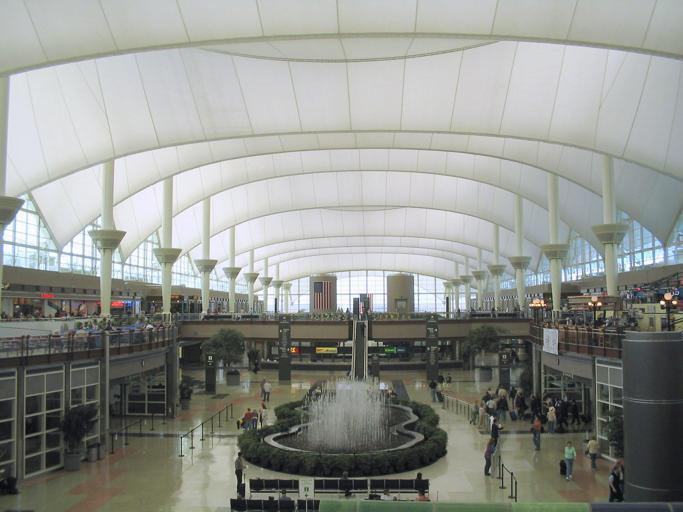

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000001.jpg')
image

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 704])


In [ ]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 176])


In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

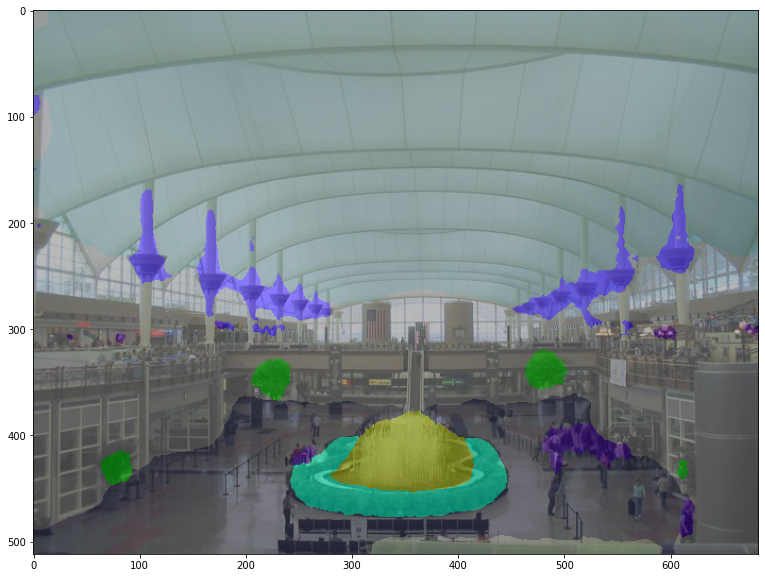

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

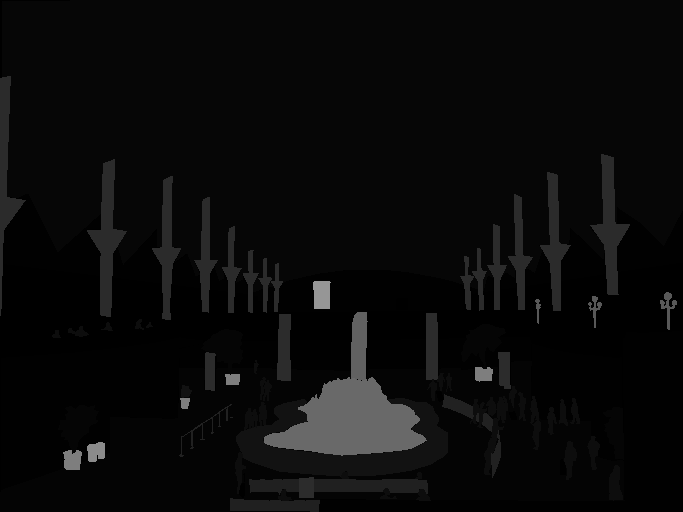

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000001.png') 
map 

Classes in this image: ['wall', 'floor', 'tree', 'ceiling', 'person', 'plant', 'seat', 'fence', 'column', 'signboard', 'streetlight', 'escalator', 'fountain', 'pot', 'ashcan', 'flag', None]


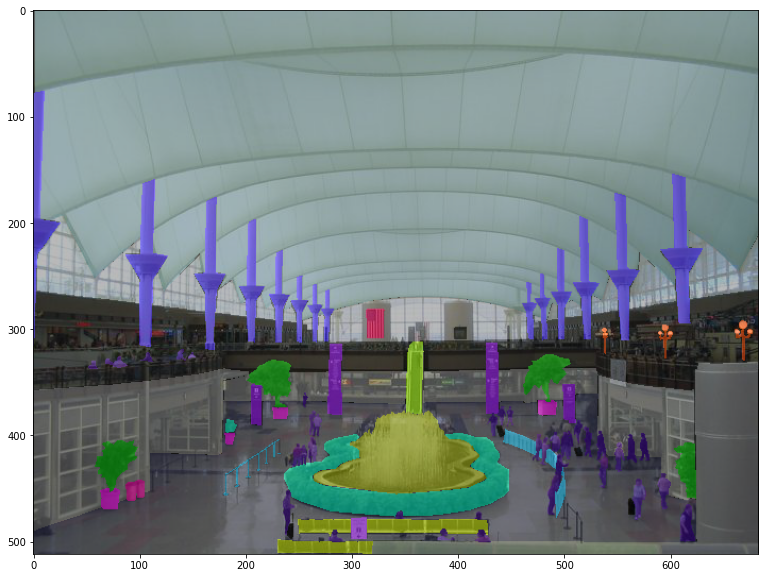

In [ ]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
seg

tensor([[0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        [0, 0, 0,  ..., 5, 5, 5],
        ...,
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0],
        [3, 3, 3,  ..., 0, 0, 0]])

In [ ]:
map

array([[255, 255, 255, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       [255, 255,   5, ...,   5,   5,   5],
       ...,
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0, 255],
       [  3,   3,   3, ...,   0,   0,   0]], dtype=uint8)

Let's compute the pixel-wise accuracy:

In [ ]:
mask = (map != 255) # we don't include the background class in the accuracy calculation
pred_labels = seg[mask].numpy()
true_labels = map[mask]

print(accuracy_score(pred_labels, true_labels))

0.8929422175983049
